# Table of Contents

* [1. Data Exploration](#1.-Data-Exploration)
* [2. Color Features Extraction](#2.-Color-Features-Extraction)
* [3. HOG Features Extraction](#3.-HOG-Features-Extraction)
* [4. Train Classifier](#4.-Train-Classifier)
* [5. Sliding Window](#5.-Sliding-Window)

In [1]:
ls

1_TrainClassifier.ipynb   model.pkl                 test_video.mp4
2_VehicleDetection.ipynb  non-vehicles/             vehicles/
README.md                 output_images/            writeup_template.md
examples/                 project_video.mp4
for_writeup/              test_images/


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

/Users/riki/.pyenv/versions/anaconda3-4.1.1/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Data Exploration

n_car 8792
n_notcars 8968
image_shape (64, 64, 3)
data_type float32


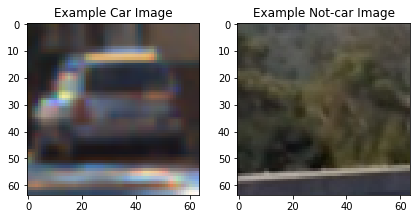

In [3]:
"""
Lecture 19. Data Exploration
"""
im_veh = glob.glob('vehicles/*/*.png')
im_nonveh = glob.glob('non-vehicles/*/*.png')

cars = []
notcars = []

for image in im_veh:
    cars.append(image)
for image in im_nonveh:
    notcars.append(image)
        
def data_look(car_list, notcar_list):
    data_dict = {}
    
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    
    return data_dict
    
data_info = data_look(cars, notcars)

print('n_car', data_info["n_cars"])
print('n_notcars', data_info["n_notcars"])
print('image_shape', data_info["image_shape"])
print('data_type', data_info["data_type"])

# plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

fig = plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.tight_layout()
fig.savefig("for_writeup/example-images.png");

# 2. Color Features Extraction

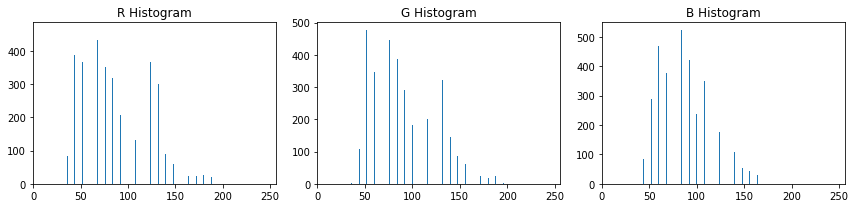

In [4]:
"""
lecture 12. Histograms of Color
"""
image = mpimg.imread('vehicles/GTI_Far/image0000.png')
image *= 255

def color_hist(img, nbins=32, bins_range=(0, 256), visualize=False):
    """color histgram features"""
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    if visualize == True: 
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        return hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256), visualize=True)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

In [5]:
image = mpimg.imread('vehicles/GTI_Far/image0000.png')

In [6]:
"""
Lecture 22. Combine and Normalize Features
"""
def bin_spatial(img, size=(32, 32)):
    """color features"""
    features = cv2.resize(img, size).ravel() 
    return features

def extract_features_color(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    """
    in: images
    out: color_feature + color_hist_feature
    """
    features = []

    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        features.append(np.concatenate((spatial_features, hist_features)))
        
    return features

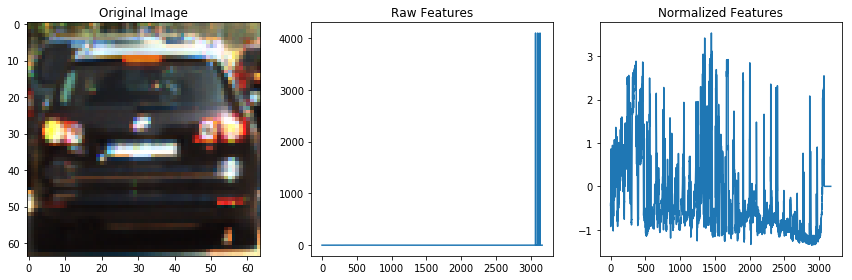

In [7]:
car_features = extract_features_color(cars)
notcar_features = extract_features_color(notcars)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

# 3. HOG Features Extraction

HOG function:
* [API reference](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog)
* [tutorial](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)

In [8]:
"""
lecture 20. scikit-image HOG
lecture 29. HOG Classify
"""
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### explore some parameters

In [9]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

/Users/riki/.pyenv/versions/anaconda3-4.1.1/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


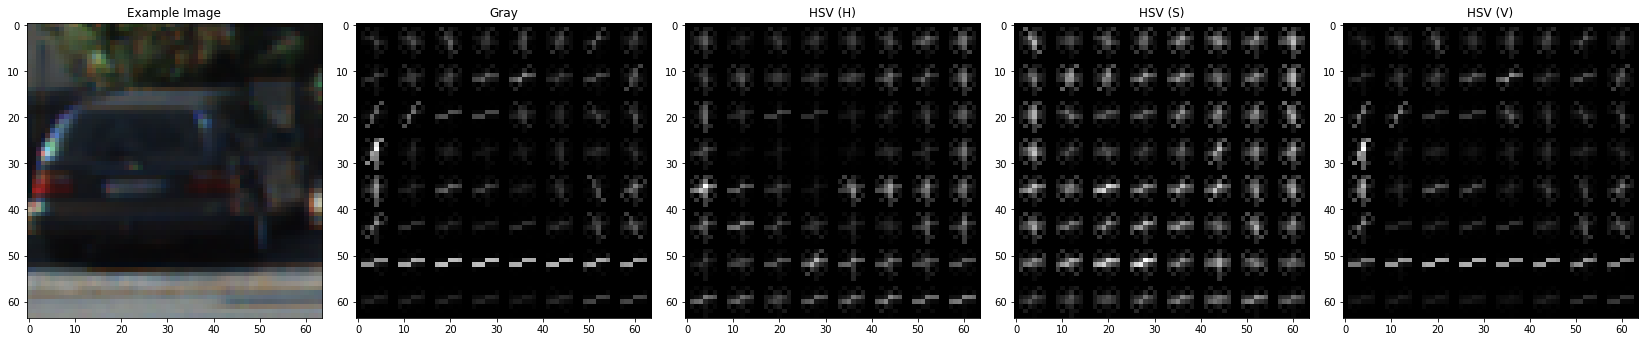

In [10]:
ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])

fig = plt.figure(figsize=(23,5))

# sample image
plt.subplot(151)
plt.imshow(image, cmap='gray')
plt.title('Example Image')

# gray
_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(_img, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
plt.subplot(152)
plt.imshow(hog_image, cmap='gray')
plt.title('Gray')

# hsv
_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

plt.subplot(153)
features, hog_image = get_hog_features(_img[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
plt.imshow(hog_image, cmap='gray')
plt.title('HSV (H)')

plt.subplot(154)
features, hog_image = get_hog_features(_img[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
plt.imshow(hog_image, cmap='gray')
plt.title('HSV (S)')

plt.subplot(155)
features, hog_image = get_hog_features(_img[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
plt.imshow(hog_image, cmap='gray')
plt.title('HSV (V)')
plt.tight_layout()
fig.savefig("for_writeup/hog-features.png");

In [11]:
def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # hog_feature (ALL channel)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, 
                                                     pix_per_cell, 
                                                     cell_per_block, 
                                                     vis=False, 
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features) 
        # hog_feature (1 channel)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, 
                                            pix_per_cell, 
                                            cell_per_block, 
                                            vis=False, 
                                            feature_vec=True)
            
        features.append(hog_features)

    return features

# 4. Train Classifier

HOG function:
* [API reference](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog)
* [tutorial](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)

In [12]:
# HOG parameters
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Color paramters
spatial = 32
histbin = 32

# feature extraction
car_features_col = extract_features_color(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features_col = extract_features_color(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
car_features_hog = extract_features_hog(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features_hog = extract_features_hog(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# X dataset
X_col = np.vstack((car_features_col, notcar_features_col)).astype(np.float64) 
X_hog = np.vstack((car_features_hog, notcar_features_hog)).astype(np.float64)   
X = np.hstack((X_col, X_hog))

/Users/riki/.pyenv/versions/anaconda3-4.1.1/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [13]:
X_col.shape, X_hog.shape, X.shape

((17760, 3168), (17760, 5292), (17760, 8460))

In [14]:
# X dataset
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Y dataset
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# train-test-split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


# training 
svc = LinearSVC(C=1.0)

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('test acc.: ', round(svc.score(X_test, y_test), 4))

32.97 Seconds to train SVC...
test acc.:  0.9854


In [15]:
# prediction
n_predict = 10
print('prediction:  ', svc.predict(X_test[0:n_predict]))
print('ground_truth:', y_test[0:n_predict])

prediction:   [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
ground_truth: [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]


In [16]:
from sklearn.externals import joblib
joblib.dump(X_scaler, 'normalizer.pkl')

['normalizer.pkl']

In [17]:
from sklearn.externals import joblib
joblib.dump(svc, 'model.pkl')

['model.pkl']